In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import requests
import json
import os, sys,gc
sys.path.append('/home/fvalle/phd/master_thesis/hsbm/')

# Download data

In [2]:
#path/to/files/downloaded/from https://doi.org/10.6084/m9.figshare.5330593
working_dir = "/home/fvalle/phd/datasets/merged/"
os.chdir(working_dir)

In [3]:
files = [f for f in os.listdir("data") if "fpkm" in f]

In [4]:
df_gtex=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)

In [5]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        }
        
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": "primary_site,disease_type,submitter_id",
    "format": "TSV",
    "size": "10000000"
    }
response = requests.get("https://api.gdc.cancer.gov/cases", headers = {"Content-Type": "application/json"}, params = params)
with open("files.txt","w") as file:
    file.write(response.content.decode("utf-8"))
    file.close()
df_tcga = pd.read_csv("files.txt", sep='\t').set_index("submitter_id")

In [8]:
df=pd.DataFrame()

In [9]:
for file in files:
    df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id',1).transpose(), sort=True)
df = df.transpose()
df = df.dropna(how='any', axis=0) # drop genes not always determined

In [10]:
df_files = pd.DataFrame(index=df.columns)

In [11]:
def get_site(file):
    if 'GTEX' in file:
        return df_gtex.at[file, 'SMTS']
    if 'TCGA' in file:
        return df_tcga.at[file[:12],'primary_site']

def get_source(file):
    if 'GTEX' in file:
        return 'gtex'
    if 'TCGA' in file:
        return 'tcga'

In [12]:
df_files.insert(0, 'primary_site', [get_site(file) for file in df.columns])
df_files.insert(1, 'dataset', [get_source(file) for file in df.columns])

## Split / shuffle and select

In [13]:
df_files.replace('Uterus, NOS', 'Uterus', inplace=True)
df_files.replace('Bronchus and lung', 'Lung', inplace=True)
df_files.replace('Liver and intrahepatic bile ducts', 'Liver', inplace=True)
df_files.replace('Prostate gland', 'Prostate', inplace=True)
df_files.replace('Thyroid gland', 'Thyroid', inplace=True)
df_files.replace('Base of Tongue', 'Salivary Gland', inplace=True)
df_files.replace('Bones, joints and articular cartilage of other and unspecified sites', 'Salivary Gland', inplace=True)
df_files.replace('Floor of mouth', 'Salivary Gland', inplace=True)
df_files.replace('Gum', 'Salivary Gland', inplace=True)
df_files.replace('Hypopharynx', 'Salivary Gland', inplace=True)
df_files.replace('Larynx', 'Salivary Gland', inplace=True)
df_files.replace('Lip', 'Salivary Gland', inplace=True)
df_files.replace('Oropharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and unspecified parts of mouth', 'Salivary Gland', inplace=True)
df_files['primary_site'].unique()

array(['Thyroid', 'Prostate', 'Rectosigmoid junction', 'Rectum',
       'Connective, subcutaneous and other soft tissues', 'Colon',
       'Esophagus', 'Salivary Gland',
       'Other and unspecified parts of tongue', 'Base of tongue',
       'Kidney', 'Liver', 'Gallbladder',
       'Other and unspecified parts of biliary tract', 'Lung',
       'Corpus uteri', 'Stomach', 'Breast', 'Uterus', 'Cervix Uteri',
       'Bladder', 'Cervix uteri', 'Tonsil', 'Palate'], dtype=object)

In [14]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/
sites_with_enough_statistics = ['Breast', 'Colon', 'Liver', 'Esophagus', 'Prostate', 'Stomach', 'Thyroid', 'Lung', 'Uterus', 'Salivary Gland']

In [15]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in sites_with_enough_statistics:
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='tcga')].sample(50, random_state=rs))
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='gtex')].sample(50, random_state=rs))

In [16]:
samples.groupby('primary_site').count()

,dataset
primary_site,
Breast,100
Colon,100
Esophagus,100
Liver,100
Lung,100
Prostate,100
Salivary Gland,100
Stomach,100
Thyroid,100


In [17]:
samples.groupby('dataset').count()

,primary_site
dataset,
gtex,500
tcga,500


In [18]:
df = df.reindex(columns=samples.index)

In [19]:
df_files.insert(0,'subset',df_files['primary_site']+'_'+df_files['dataset'])
df_files.to_csv("files.dat", index=True, header=True)

# Use scanpy to filter HVG

In [20]:
adata = sc.AnnData(df.transpose(), obs=samples)

In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, n_bins=50)

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/scanpy/plotting/_utils.py:235: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


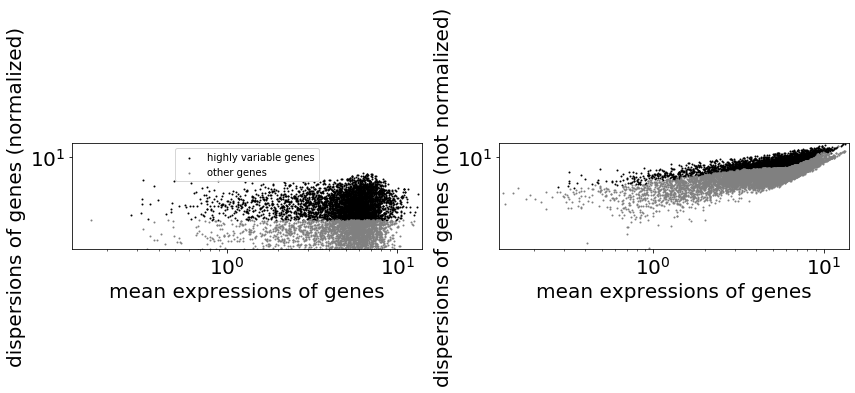

In [23]:
sc.pl.highly_variable_genes(adata, log=True, save='hvg.pdf')

In [24]:
hvg = adata.var[adata.var['highly_variable']==True].index
samples = adata.obs.index

# Use SBM

In [25]:
from sbmtm import sbmtm

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/draw/libgraph_tool_draw.so: undefined symbol: _ZN5Cairo7Context9show_textERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(msg, RuntimeWarning)


In [26]:
model = sbmtm()

In [ ]:
model.make_graph_from_BoW_df(df.loc[hvg, samples])

In [ ]:
model.save_graph("graph.xml.gz")

In [ ]:
gc.collect()

,TCGA-B6-A0RV-01A-11R-A084-07,TCGA-BH-A1EU-01A-11R-A137-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-B6-A0RS-01A-11R-A084-07,TCGA-A8-A06N-01A-11R-A00Z-07,TCGA-AR-A2LL-01A-11R-A180-07,TCGA-BH-A0HL-01A-11R-A10U-07,TCGA-A8-A09Q-01A-11R-A00Z-07,TCGA-BH-A1FR-01A-11R-A13Q-07,TCGA-A8-A07B-01A-11R-A00Z-07,...,GTEX-11WQK-2926-SM-5EQKT,GTEX-13111-2326-SM-5LZUQ,GTEX-13QJC-2326-SM-5Q5CD,GTEX-ZA64-1726-SM-5CVMF,GTEX-13O21-1926-SM-5MR39,GTEX-11NV4-1926-SM-5N9D4,GTEX-12WSL-2126-SM-5GCNG,GTEX-XMK1-2626-SM-4B65R,GTEX-WOFM-2126-SM-4OOSR,GTEX-13VXT-1726-SM-5IFF5
A1BG,1159.07,244.57,166.73,674.59,497.00,1250.98,1359.57,1081.39,656.11,376.41,...,175.07,72.52,124.37,199.85,183.82,215.77,144.01,120.94,232.94,248.00
A2M,5913.33,10808.41,13399.51,4450.27,1175.27,3690.52,1191.69,7180.15,4358.66,2796.65,...,2032.85,6294.04,3212.66,2720.15,1883.54,1208.34,1709.26,6840.04,1909.85,113.56
A2ML1,1.71,4.66,6.52,0.00,0.65,1.95,0.36,1.17,3.59,37.59,...,703.28,323.03,819.30,6792.79,1037.29,115.16,529.06,2240.11,15499.21,536.45
A4GALT,536.45,177.53,279.14,176.29,45.85,376.41,128.79,157.68,100.13,152.28,...,1143.10,1225.22,480.04,728.11,432.53,1572.76,2520.38,780.44,366.09,187.71
A4GNT,0.34,0.74,2.10,0.00,0.00,0.65,1.23,0.77,0.33,0.00,...,0.04,1.22,0.87,1.30,1.03,0.00,0.00,0.13,0.68,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,180.02,277.20,316.37,169.07,206.94,137.14,165.57,197.09,195.72,143.01,...,197.09,267.73,159.90,165.57,185.11,132.44,138.10,144.01,165.57,112.77
ZYX,2075.59,2178.83,2303.12,4210.15,525.39,2417.67,1250.98,1923.14,1923.14,1572.76,...,3349.13,6121.90,3665.02,7331.05,2573.36,2090.03,3039.30,5711.87,4419.52,1159.07
ZZEF1,195.72,511.00,417.77,126.12,239.52,146.03,339.14,279.14,255.00,379.04,...,241.19,228.13,332.14,255.00,303.44,356.05,249.73,202.66,423.61,423.61
ZZZ3,507.46,796.86,660.68,249.73,819.30,314.17,529.06,381.68,896.64,441.64,...,236.21,384.34,334.46,215.77,363.56,285.03,253.23,258.57,403.50,173.85
